##### Import

In [1]:
from google.colab import drive
drive.mount('/gdrive',force_remount=True)

Mounted at /gdrive


In [ ]:
!pip install regressors

In [3]:
#System imports
import sys
import glob
import os
import subprocess
import shutil
import datetime
from functools import reduce

#Data manipulation imports
import pandas as pd
import numpy as np
from regressors import stats
import math
import re
import itertools
import pickle

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt

In [4]:
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, mean_squared_error

#### Data Preparation

##### Read Data

In [7]:
df_full = pd.read_csv('/gdrive/MyDrive/000 Spring 2022/ML/ML_FinalProject/fulldata_impute.csv')

In [14]:
df_full.columns

Index(['dsny_namecode', 'year', 'time', 'cont', 'ton', 'namecode_tds', 'SD',
       'units_S8', 'units_current', 'units_total', 'number_rental_rooms',
       'population_S8', 'population_PH', 'population_total',
       'residential_buildings', 'non-residential_buildings', 'stairhalls',
       'total_sqft', 'acres', 'net_dev_sqft', 'acres_nopark',
       'bldg_coverage_sqft', 'cubage_cuft', 'development_cost',
       'families_on_fixed_income', 'ave_r_per_unit', 'density_PopPerSqFt',
       'density_PopPerDevFt', 'density_PopPerCubage',
       'cost_per_rental_room_ab', 'bldg_land_ratio', 'avg_m_gross_rent',
       'pct_families_on_fixed_income', 'dev_name', 'extcomp', 'waste_yard',
       'intcomp', 'rec_bins', 'balers', 'bulk_conts', 'per_unit_rb',
       'per_capita_rb', 'Avg Temperature', 'Precipitation', 'Snowdepth',
       'label_n4', 'C1', 'C2', 'C3', 'C4', 'HeavyPre', 'Snow', 'month',
       'January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'Septem

##### Dataset 1: All consolidations

In [32]:
df_model = df_full[df_full.time < '2021-09-01']
df_validation = df_full[df_full.time > '2021-08-01']

In [12]:
if len(df_model) + len(df_validation) == len(df_full):
  print('Split is successful.')

Split is successful.


In [13]:
#df_model.to_csv('/gdrive/MyDrive/000 Spring 2022/Thesis Capstone/Data/Interim/modeldata_impute.csv', index = False)
#df_validation.to_csv('/gdrive/MyDrive/000 Spring 2022/Thesis Capstone/Data/Interim/validationdata_impute.csv', index = False)

##### Dataset 2: Remove outliers 

In [10]:
outlier = ['baruch', 'monterey', 'cassidylafayette', 'drewhamilton', 'careygardens', 'wyckoffgardens', 
           'morrisaniaairrights', 'redfern', 'baileyavenuewest193rdstreet', 'audubon', 'sheepsheadbay', 
           'campos', 'taylor', 'chelsea', 'seward']

In [19]:
df_model = df_model[~df_model['dsny_namecode'].isin(outlier)].reset_index(drop = True)
df_validation = df_validation[~df_validation['dsny_namecode'].isin(outlier)].reset_index(drop = True)

##### Shuffling

In [33]:
df_model = df_model.sample(frac=1)

##### Features

In [34]:
# drop columns with NaN value: pct family on fixed income
df_model = df_model.dropna(axis = 1)

In [ ]:
df_model.columns

Index(['dsny_namecode', 'year', 'time', 'cont', 'ton', 'namecode_tds', 'SD',
       'units_S8', 'units_current', 'units_total', 'number_rental_rooms',
       'population_S8', 'population_PH', 'population_total',
       'residential_buildings', 'non-residential_buildings', 'stairhalls',
       'total_sqft', 'acres', 'net_dev_sqft', 'acres_nopark',
       'bldg_coverage_sqft', 'cubage_cuft', 'development_cost',
       'families_on_fixed_income', 'ave_r_per_unit', 'density_PopPerSqFt',
       'density_PopPerDevFt', 'density_PopPerCubage',
       'cost_per_rental_room_ab', 'bldg_land_ratio', 'avg_m_gross_rent',
       'dev_name', 'extcomp', 'waste_yard', 'intcomp', 'rec_bins', 'balers',
       'bulk_conts', 'per_unit_rb', 'per_capita_rb', 'Avg Temperature',
       'Precipitation', 'Snowdepth', 'label_n4', 'C1', 'C2', 'C3', 'C4',
       'HeavyPre', 'Snow', 'month', 'January', 'February', 'March', 'April',
       'May', 'June', 'July', 'August', 'September', 'October', 'November',
       'De

In [66]:
var_binary = ['SD', 'C1', 'C2', 'C3', 'C4', 
              'pandemic', 'HeavyPre', 'Snow']

var_numeric = ['units_total', 
               #'number_rental_rooms','population_total',
       'residential_buildings', 'stairhalls',
       'total_sqft', 'acres', 
       'net_dev_sqft', 'acres_nopark',
       'nondev_sqft', 'park_acres', 
       'bldg_coverage_sqft', 
       'cubage_cuft', 
       'bldg_land_ratio', 
       'development_cost', 'cost_per_rental_room_ab', 
       'families_on_fixed_income', 'avg_m_gross_rent',
       'ave_r_per_unit', 
       'density_PopPerSqFt','density_PopPerDevFt', 'density_PopPerCubage',
        'per_unit_rb', 'per_capita_rb',
        'ave_height', 'ave_bldg_sqft',
        'Avg Temperature']

# 'population_S8', 'population_PH', 

In [67]:
X_num = df_model[var_numeric].values
X_bi = df_model[var_binary].values

y = df_model['rolling_ton']

##### Scaling

In [68]:
# Standardize numeric variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_num = scaler.fit_transform(df_model[var_numeric].values)

In [26]:
# Normalize numeric variables
#from sklearn.preprocessing import Normalizer
#normalizer = Normalizer()
#X_num = normalizer.fit_transform(df_model[var_numeric].values)

In [27]:
# Standardize y
#scaler = StandardScaler()
#y_std = scaler.fit_transform(df_model['rolling_ton'].values.reshape(-1, 1))

##### Train Test Split

In [69]:
Xy = np.hstack((X_num, X_bi, y.values.reshape(-1, 1)))

In [70]:
X_train, X_test, y_train, y_test = train_test_split(Xy[:, :-1], Xy[:,-1], train_size = .75, random_state=3)
print("Train sample (X):", len(X_train))
print("Train sample (y):", len(y_train))
print("Test sample (X):", len(X_test))
print("Test sample (y):", len(y_test))

Train sample (X): 5229
Train sample (y): 5229
Test sample (X): 1744
Test sample (y): 1744


In [71]:
X_train.shape

(5229, 33)

## Linear Models

##### OLS Regression - Ave Temp

In [137]:
lr_OLS = LinearRegression().fit(X_train, y_train)

y_pred_train = lr_OLS.predict(X_train)
y_pred_test = lr_OLS.predict(X_test)

print("Training Set Score: %.2f" % lr_OLS.score(X_train, y_train))
print("Mean Squared Error (training set): %.2f" % mean_squared_error(y_train, y_pred_train))
print("Testing Set Score: %.2f" % lr_OLS.score(X_test, y_test))
print("Mean Squared Error (testing set): %.2f" % mean_squared_error(y_test, y_pred_test))

Training Set Score: 0.81
Mean Squared Error (training set): 442.90
Testing Set Score: 0.81
Mean Squared Error (testing set): 456.57


In [73]:
result = pd.DataFrame(columns = ['Predictors', 'Coefficients', 'p_values'])
result['Predictors'] = var_binary+ var_numeric
result['Coefficients'] = lr_OLS.coef_
result['p_values'] = stats.coef_pval(lr_OLS, X_train.astype(float), y_train.astype(float))[1:]
result['*'] = result['p_values']<0.05
result 

,Predictors,Coefficients,p_values,*
0,SD,5.871138,9.428424e-02,False
1,C1,-12.830912,0.000000e+00,True
2,C2,-4.258498,6.667263e-09,True
3,C3,497.432805,9.999535e-01,False
4,C4,-490.190780,9.999398e-01,False
5,pandemic,532.926801,9.999380e-01,False
6,HeavyPre,-524.050287,9.999201e-01,False
7,Snow,107.804628,9.996919e-01,False
8,units_total,-110.517921,9.995867e-01,False
9,residential_buildings,0.834975,6.220285e-01,False


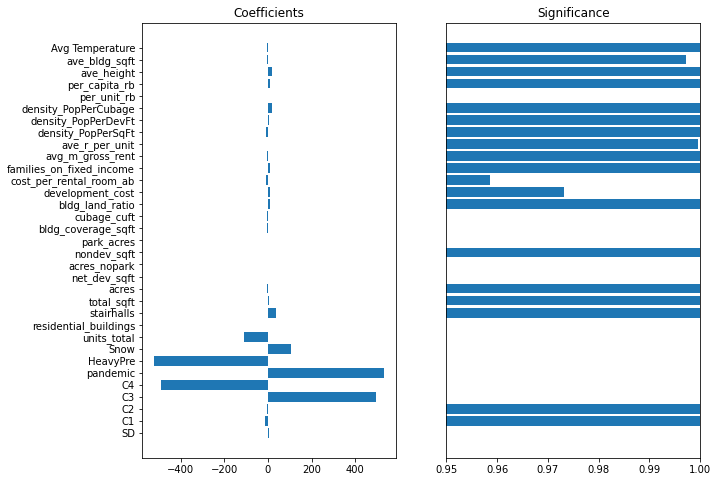

In [74]:
fig, ax = plt.subplots(figsize=(10, 8), nrows = 1, ncols = 2)

ax[0].barh(y = result['Predictors'], width = result['Coefficients'])
ax[0].set_title("Coefficients", fontsize=14)
ax[0].set_title('Coefficients')
#ax[0].set_xticklabels(  ax[0].get_xticklabels(),rotation=45, ha='right')
#plt.setp(ax[0].get_xticklabels(), rotation=45, ha="right",
         #rotation_mode="anchor")
#plt.grid()

ax[1].barh(y = result['Predictors'], width = 1- result['p_values'])
ax[1].set_yticks([])
ax[1].set_title('Significance')
plt.xlim(0.95, 1)

plt.show()


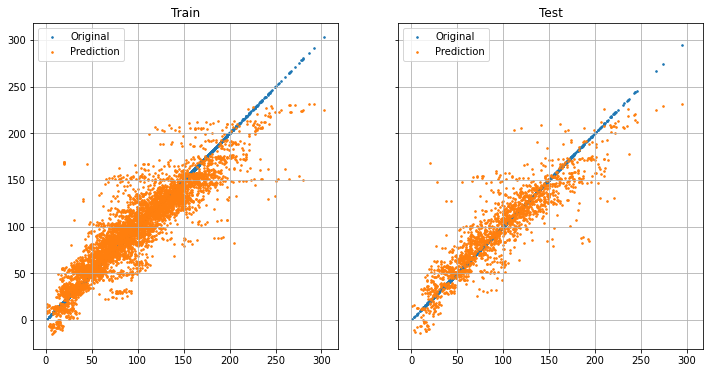

In [75]:
fig, ax = plt.subplots(figsize = (12, 6), nrows =1, ncols=2, sharex=True, sharey=True)

ax[0].scatter(x = y_train, y = y_train, s = 2.5, label = 'Original')
ax[0].scatter(x = y_train, y = y_pred_train, s = 2.5, label = 'Prediction')
#plt.ylim(0, 0.1)
#plt.xticks(rotation=45, ha='right')
ax[0].grid()
ax[0].set_title('Train')
ax[0].legend()

ax[1].scatter(x = y_test, y = y_test, s = 2.5, label = 'Original')
ax[1].scatter(x = y_test, y = y_pred_test, s = 2.5, label = 'Prediction')
ax[1].grid()
ax[1].set_title('Test')
ax[1].legend()

plt.show()

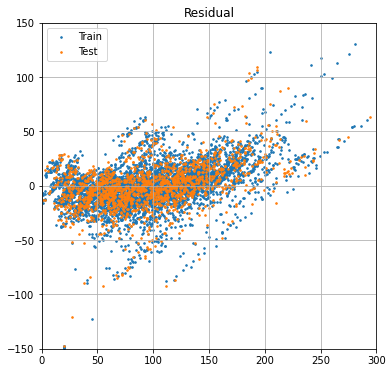

In [76]:
res_train =  y_train - y_pred_train
res_test = y_test - y_pred_test

fig, ax = plt.subplots(figsize = (6, 6), nrows =1, ncols=1, sharex=True, sharey=True)

ax.scatter(x = y_train, y= res_train, s = 2.5, label = 'Train')
ax.scatter(x = y_test, y = res_test, s = 2.5, label = 'Test')
plt.xlim(0, 300)
plt.ylim(-150, 150)
#plt.xticks(rotation=45, ha='right')
ax.grid()
ax.set_title('Residual')
ax.legend()
'''
ax[1].scatter(x = y_test, y = y_test, s = 2.5, label = 'Original')
ax[1].scatter(x = y_test, y = y_pred_test, s = 2.5, label = 'Prediction')
ax[1].grid()
ax[1].set_title('Test')
ax[1].legend()
'''
plt.show()

In [138]:
filename = '/gdrive/MyDrive/000 Spring 2022/ML/ML_FinalProject/OLS.sav'
pickle.dump(lr_OLS, open(filename, 'wb'))

##### Lasso

In [77]:
lr_lasso = Lasso().fit(X_train, y_train) # trained model
y_pred_train = lr_lasso.predict(X_train)
y_pred_test = lr_lasso.predict(X_test)

print("Training score: %.3f" % lr_lasso.score(X_train, y_train))
print("Testing score: %.3f" % lr_lasso.score(X_test, y_test))

print("Mean Squared Error: %.3f" % mean_squared_error(y_pred_train, y_train))
print("Mean Squared Error %.3f" % mean_squared_error(y_pred_test, y_test))

print("Number of features used:", np.sum(lr_lasso.coef_ != 0))

Training score: 0.784
Testing score: 0.767
Mean Squared Error: 515.756
Mean Squared Error 551.776
Number of features used: 15


In [78]:
# With alpha = 0.001
lasso = Lasso(alpha=0.001).fit(X_train, y_train)
print ("Training set score: %.3f"% lasso.score(X_train, y_train))
print ("Test set score: %.3f"% lasso.score(X_test, y_test))

print('Mean squared error (training set): %.2f'% mean_squared_error(y_train, lasso.predict(X_train)))
print('Mean squared error (test set): %.2f'% mean_squared_error(y_test, lasso.predict(X_test)))

# The number of features used for the modeling
# If the model panalize too much, then the model lose lots of predictors
print("Number of features used:", np.sum(lasso.coef_ != 0)) 

Training set score: 0.814
Test set score: 0.807
Mean squared error (training set): 442.99
Mean squared error (test set): 457.09
Number of features used: 31


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.709e+05, tolerance: 1.249e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [79]:
# With alpha = 0.01
lasso = Lasso(alpha=0.01).fit(X_train, y_train)
print ("Training set score: %.3f"% lasso.score(X_train, y_train))
print ("Test set score: %.3f"% lasso.score(X_test, y_test))

print('Mean squared error (training set): %.2f'% mean_squared_error(y_train, lasso.predict(X_train)))
print('Mean squared error (test set): %.2f'% mean_squared_error(y_test, lasso.predict(X_test)))

# The number of features used for the modeling
# If the model panalize too much, then the model lose lots of predictors
print("Number of features used:", np.sum(lasso.coef_ != 0)) 

Training set score: 0.814
Test set score: 0.807
Mean squared error (training set): 443.14
Mean squared error (test set): 457.95
Number of features used: 31


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.065e+04, tolerance: 1.249e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [80]:
# With alpha = 0.5
lasso = Lasso(alpha=0.5).fit(X_train, y_train)
print ("Training set score: %.3f"% lasso.score(X_train, y_train))
print ("Test set score: %.3f"% lasso.score(X_test, y_test))

print('Mean squared error (training set): %.2f'% mean_squared_error(y_train, lasso.predict(X_train)))
print('Mean squared error (test set): %.2f'% mean_squared_error(y_test, lasso.predict(X_test)))

# The number of features used for the modeling
# If the model panalize too much, then the model lose lots of predictors
print("Number of features used:", np.sum(lasso.coef_ != 0)) 

Training set score: 0.802
Test set score: 0.787
Mean squared error (training set): 473.55
Mean squared error (test set): 503.33
Number of features used: 18


In [81]:
# With alpha = 1
lasso = Lasso(alpha=1).fit(X_train, y_train)
print ("Training set score: %.3f"% lasso.score(X_train, y_train))
print ("Test set score: %.3f"% lasso.score(X_test, y_test))

print('Mean squared error (training set): %.2f'% mean_squared_error(y_train, lasso.predict(X_train)))
print('Mean squared error (test set): %.2f'% mean_squared_error(y_test, lasso.predict(X_test)))

# The number of features used for the modeling
# If the model panalize too much, then the model lose lots of predictors
print("Number of features used:", np.sum(lasso.coef_ != 0)) 

Training set score: 0.784
Test set score: 0.767
Mean squared error (training set): 515.76
Mean squared error (test set): 551.78
Number of features used: 15


In [83]:
# With alpha = 2
lasso = Lasso(alpha=2).fit(X_train, y_train)
print ("Training set score: %.3f"% lasso.score(X_train, y_train))
print ("Test set score: %.3f"% lasso.score(X_test, y_test))

print('Mean squared error (training set): %.2f'% mean_squared_error(y_train, lasso.predict(X_train)))
print('Mean squared error (test set): %.2f'% mean_squared_error(y_test, lasso.predict(X_test)))

# The number of features used for the modeling
# If the model panalize too much, then the model lose lots of predictors
print("Number of features used:", np.sum(lasso.coef_ != 0)) 

Training set score: 0.769
Test set score: 0.751
Mean squared error (training set): 552.02
Mean squared error (test set): 590.30
Number of features used: 11


In [84]:
# With alpha = 5
lasso = Lasso(alpha=5).fit(X_train, y_train)
print ("Training set score: %.3f"% lasso.score(X_train, y_train))
print ("Test set score: %.3f"% lasso.score(X_test, y_test))

print('Mean squared error (training set): %.2f'% mean_squared_error(y_train, lasso.predict(X_train)))
print('Mean squared error (test set): %.2f'% mean_squared_error(y_test, lasso.predict(X_test)))

# The number of features used for the modeling
# If the model panalize too much, then the model lose lots of predictors
print("Number of features used:", np.sum(lasso.coef_ != 0)) 

Training set score: 0.724
Test set score: 0.708
Mean squared error (training set): 659.53
Mean squared error (test set): 691.04
Number of features used: 4


##### Lasso - Lambda Selection

In [86]:
# Create a list of lambdas (alpha) from 0 to 20, evenly spaced 1000 numbers
lambdas = np.linspace(0, 5,1000)

# Create empty lists
list_train = [] # it will store train R2
list_test = [] # it will stroe test R2
list_gap = [] # it will store gap values between train R2 and test R2
list_num_features = [] # it will store the number of features used for modeling

list_train_e = [] # it will store train R2
list_test_e = [] # it will stroe test R2
list_gap_e = [] # it will store gap values between train R2 and test R2

for alpha in lambdas:
    lasso = Lasso(alpha=alpha).fit(X_train, y_train) # Train ridge model using specified alpha (lambda)
    
    y_pred_train = lasso.predict(X_train)
    y_pred_test = lasso.predict(X_test)

    list_train.append(lasso.score(X_train, y_train))
    list_test.append(lasso.score(X_test, y_test))
    list_gap.append(np.abs(lasso.score(X_train, y_train) - lasso.score(X_test, y_test)))
    list_num_features.append(np.sum(lasso.coef_ != 0))


    list_train_e.append(mean_squared_error(y_train, y_pred_train))
    list_test_e.append(mean_squared_error(y_test, y_pred_test))
    list_gap_e.append(np.abs(mean_squared_error(y_train, y_pred_train)-mean_squared_error(y_test, y_pred_test)))


print ("The list of R2 values (training set):", list_train[:3]) # print only first three itmes due to the length
print ("The list of R2 values (test set):", list_test[:3]) # print only first three itmes due to the length
print ("The list of gap between two values:", list_gap[:3]) # print only first three itmes due to the length
print ("The list of #of used features:", list_num_features[:3])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.158e+06, tolerance: 1.249e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, l1_reg, l2_re

The list of R2 values (training set): [0.8144899601629059, 0.8144702688342917, 0.8144249311318089]
The list of R2 values (test set): [0.8070317348464184, 0.8068351425038632, 0.8066266780820727]
The list of gap between two values: [0.007458225316487432, 0.00763512633042851, 0.007798253049736248]
The list of #of used features: [33, 31, 31]


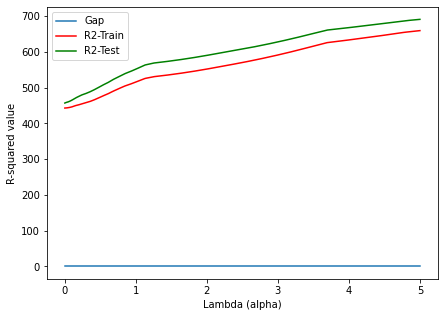

In [87]:
plt.figure(figsize=(7,5))

plt.plot(lambdas, list_gap, label='Gap')
plt.plot(lambdas, list_train_e, c='Red', label='R2-Train') 
plt.plot(lambdas, list_test_e, c='Green', label='R2-Test')

plt.xlabel("Lambda (alpha)")
plt.ylabel("R-squared value")

plt.legend()

In [88]:
p = list_gap_e.index(min(list_gap_e))

In [ ]:
list_gap

In [90]:
lambdas[p]

0.0

In [91]:
final_lasso = Lasso(alpha=lambdas[p]).fit(X_train, y_train)

# Predict values based on train set (after this step, we will compare y_train vs, y_pred)
y_pred_train = final_lasso.predict(X_train)

# Model performance (training model)
print ("Training set score: %.2f"% final_lasso.score(X_train, y_train))
print('Mean squared error (training set): %.2f'% mean_squared_error(y_train, y_pred_train))

# Predict values based on test set
y_pred_test = final_lasso.predict(X_test)

# Evaluation of our test
print ("Test set score: %.2f"% final_lasso.score(X_test, y_test))
print('Mean squared error (test set): %.2f'% mean_squared_error(y_test, y_pred_test))

print ("The number of features used =",np.sum(final_lasso.coef_ != 0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.158e+06, tolerance: 1.249e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, l1_re

Training set score: 0.81
Mean squared error (training set): 442.99
Test set score: 0.81
Mean squared error (test set): 456.99
The number of features used = 33


In [92]:
result = pd.DataFrame(columns = ['Predictors', 'Coefficients', 'p_values'])
result['Predictors'] = var_numeric + var_binary
result['Coefficients'] = final_lasso.coef_
result['p_values'] = stats.coef_pval(final_lasso, X_train.astype(float), y_train.astype(float))[1:]
result['*'] = result['p_values']<0.01
#result 

In [93]:
result = result.sort_values(by = 'p_values', ascending = False)

Text(0.5, 1.0, '$\\lambda = 0.0$')

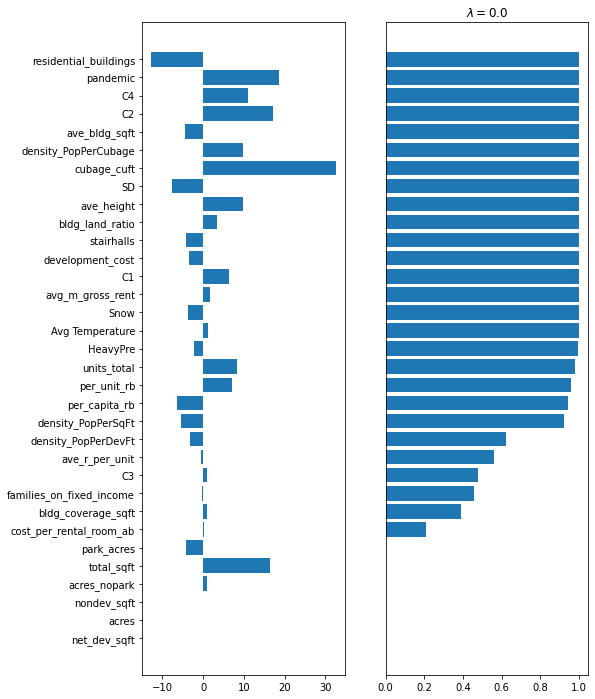

In [94]:
plt.figure(figsize=(8, 12))

plt.subplot(1, 2, 1)
plt.barh(y = result['Predictors'], width = result['Coefficients'])
#plt.xticks(rotation=45, ha='right')
#plt.axis('off')
#plt.grid()

plt.subplot(1, 2, 2)
plt.barh(y = result['Predictors'], width = 1- result['p_values'])
#plt.xticks(rotation=45, ha='right')
#plt.ylim(0.99, 1)
plt.yticks([])
plt.title('$\lambda = {}$'.format(round(lambdas[p], 2)))

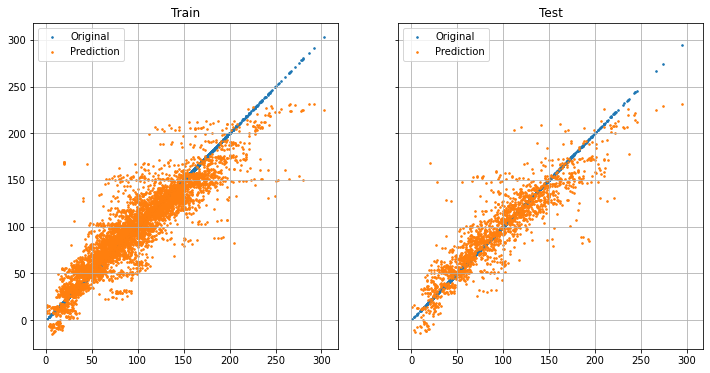

In [95]:
fig, ax = plt.subplots(figsize = (12, 6), nrows =1, ncols=2, sharex=True, sharey=True)

ax[0].scatter(x = y_train, y = y_train, s = 2.5, label = 'Original')
ax[0].scatter(x = y_train, y = y_pred_train, s = 2.5, label = 'Prediction')
#plt.ylim(0, 0.1)
#plt.xticks(rotation=45, ha='right')
ax[0].grid()
ax[0].set_title('Train')
ax[0].legend()

ax[1].scatter(x = y_test, y = y_test, s = 2.5, label = 'Original')
ax[1].scatter(x = y_test, y = y_pred_test, s = 2.5, label = 'Prediction')
ax[1].grid()
ax[1].set_title('Test')
ax[1].legend()

plt.show()

In [136]:
filename = '/gdrive/MyDrive/000 Spring 2022/ML/ML_FinalProject/Lasso.sav'
pickle.dump(final_lasso, open(filename, 'wb'))

## Decision Tree

In [96]:
from sklearn import tree

##### DT, full tree

In [97]:
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [98]:
print("Training score: %.3f" % clf.score(X_train, y_train))
print("Testing score: %.3f" % clf.score(X_test, y_test))

print("Mean Squared Error: %.3f" % mean_squared_error(y_pred_train, y_train))
print("Mean Squared Error %.3f" % mean_squared_error(y_pred_test, y_test))

Training score: 1.000
Testing score: 0.924
Mean Squared Error: 0.000
Mean Squared Error 180.899


In [100]:
result = pd.DataFrame(columns = ['Predictors', 'Importance'])
result['Predictors'] = var_numeric + var_binary
result['Importance'] = clf.feature_importances_
result = result.sort_values(by = ['Importance'])

#result['p_values'] = stats.coef_pval(lr_OLS, X_train, y_train)[1:]
#result['*'] = result['p_values']<0.01

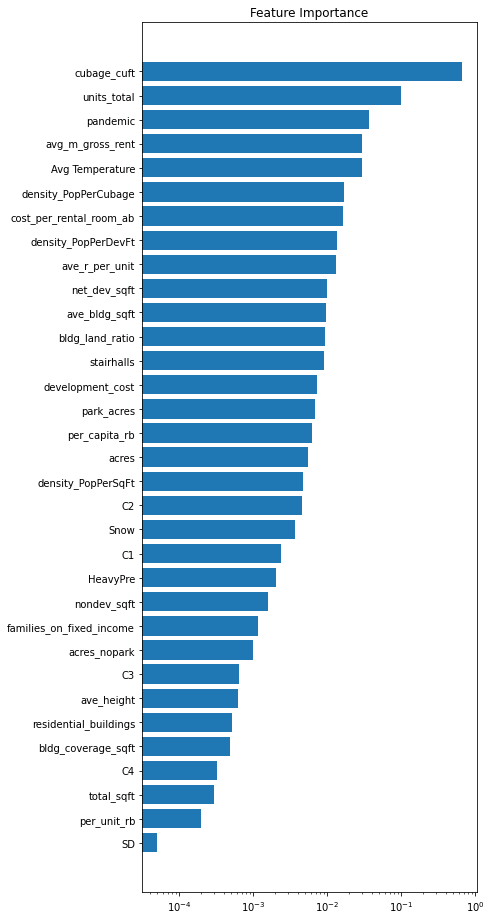

In [101]:
fig = plt.figure(figsize = (6, 16))
plt.barh(y = result['Predictors'], width = result['Importance'], log = True)
# plt.ylim(0, 0.1)
#plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance')
plt.show()

##### DT, Maxdepth = 10

In [102]:
# max_depth = 10
clf = tree.DecisionTreeRegressor(max_depth = 10)
clf = clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [108]:
print("Training score: %.3f" % clf.score(X_train, y_train))
print("Testing score: %.3f" % clf.score(X_test, y_test))

print("Mean Squared Error: %.3f" % mean_squared_error(y_pred_train, y_train))
print("Mean Squared Error %.3f" % mean_squared_error(y_pred_test, y_test))

Training score: 0.959
Testing score: 0.931
Mean Squared Error: 96.857
Mean Squared Error 163.804


In [ ]:
fig, ax = plt.subplots(figsize=(16, 16))
tree.plot_tree(clf)

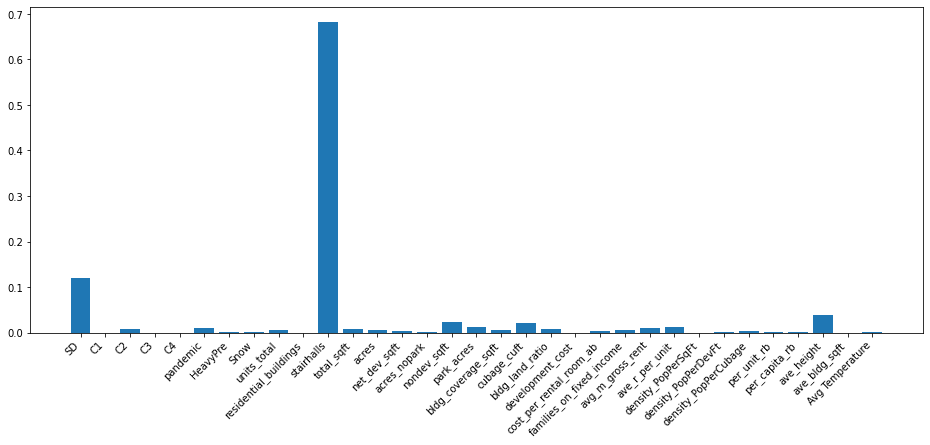

In [109]:
result = pd.DataFrame(columns = ['Predictors', 'Importance'])
result['Predictors'] = var_binary+var_numeric
result['Importance'] = clf.feature_importances_
#result['p_values'] = stats.coef_pval(lr_OLS, X_train, y_train)[1:]
#result['*'] = result['p_values']<0.01

fig = plt.figure(figsize = (16, 6))
plt.bar(x = result['Predictors'], height = result['Importance'])
#plt.ylim(0, 0.1)
plt.xticks(rotation=45, ha='right')
plt.show()

In [107]:
clf.decision_path(X_train)

<5229x1411 sparse matrix of type '<class 'numpy.int64'>'
	with 57283 stored elements in Compressed Sparse Row format>

##### DT, Maxdepth = 4

In [ ]:
# max_depth = 4
clf = tree.DecisionTreeRegressor(max_depth = 4)
clf = clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [ ]:
print("Training score: %.3f" % clf.score(X_train, y_train))
print("Testing score: %.3f" % clf.score(X_test, y_test))

print("Mean Squared Error: %.3f" % mean_squared_error(y_pred_train, y_train))
print("Mean Squared Error %.3f" % mean_squared_error(y_pred_test, y_test))

Training score: 0.778
Testing score: 0.780
Mean Squared Error: 0.222
Mean Squared Error 0.219


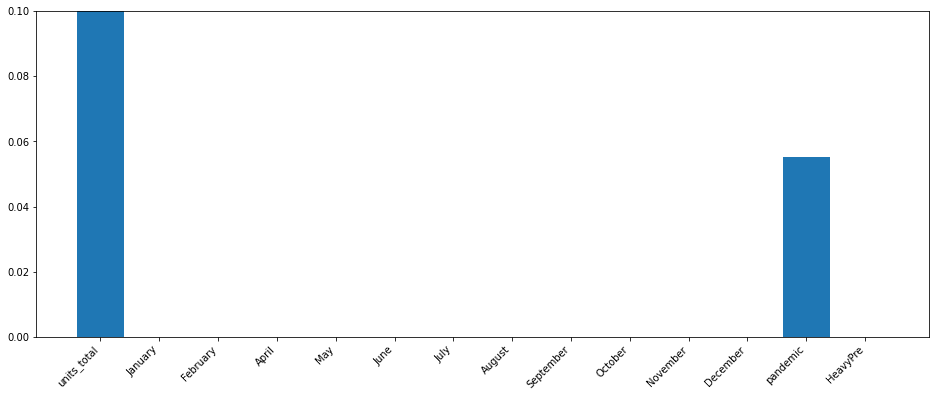

In [ ]:
result = pd.DataFrame(columns = ['Predictors', 'Importance'])
result['Predictors'] = var_list
result['Importance'] = clf.feature_importances_
#result['p_values'] = stats.coef_pval(lr_OLS, X_train, y_train)[1:]
#result['*'] = result['p_values']<0.01

fig = plt.figure(figsize = (16, 6))
plt.bar(x = result['Predictors'], height = result['Importance'])
plt.ylim(0, 0.1)
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(32, 16))
tree.plot_tree(clf,feature_names = var_list, fontsize = 10)

In [ ]:
fig, ax = plt.subplots(figsize = (12, 6), nrows =1, ncols=2, sharex=True, sharey=True)

ax[0].scatter(x = y_train, y = y_train, s = 2.5, label = 'Original')
ax[0].scatter(x = y_train, y = y_pred_train, s = 2.5, label = 'Prediction')
#plt.ylim(0, 0.1)
#plt.xticks(rotation=45, ha='right')
ax[0].grid()
ax[0].set_title('Train')
ax[0].legend()

ax[1].scatter(x = y_test, y = y_test, s = 2.5, label = 'Original')
ax[1].scatter(x = y_test, y = y_pred_test, s = 2.5, label = 'Prediction')
ax[1].grid()
ax[1].set_title('Test')
ax[1].legend()

plt.show()

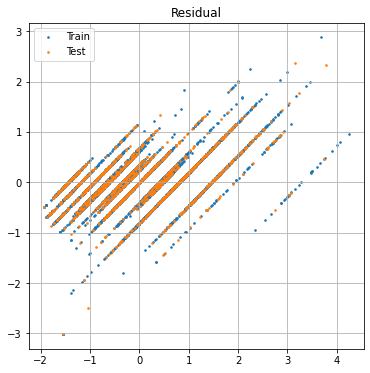

In [ ]:
res_train =  y_train - y_pred_train
res_test = y_test - y_pred_test

fig, ax = plt.subplots(figsize = (6, 6), nrows =1, ncols=1, sharex=True, sharey=True)

ax.scatter(x = y_train, y= res_train, s = 2.5, label = 'Train')
ax.scatter(x = y_test, y = res_test, s = 2.5, label = 'Test')
#plt.xlim(0, 300)
#plt.ylim(-150, 150)
#plt.xticks(rotation=45, ha='right')
ax.grid()
ax.set_title('Residual')
ax.legend()
'''
ax[1].scatter(x = y_test, y = y_test, s = 2.5, label = 'Original')
ax[1].scatter(x = y_test, y = y_pred_test, s = 2.5, label = 'Prediction')
ax[1].grid()
ax[1].set_title('Test')
ax[1].legend()
'''
plt.show()

##### DT, GridSearch

In [110]:
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth':range(5,15)}
DT = tree.DecisionTreeRegressor()
clf = GridSearchCV(DT, parameters)
clf.fit(X_train,y_train)
print('Best parameters:', clf.best_params_)
print('Score from cross-validation: {:.5f}'.format(clf.best_score_))

Best parameters: {'max_depth': 11}
Score from cross-validation: 0.92703


In [133]:
clf = tree.DecisionTreeRegressor(max_depth = 11)
clf = clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print("Training score: %.3f" % clf.score(X_train, y_train))
print("Testing score: %.3f" % clf.score(X_test, y_test))

print("Mean Squared Error: %.3f" % mean_squared_error(y_pred_train, y_train))
print("Mean Squared Error %.3f" % mean_squared_error(y_pred_test, y_test))

Training score: 0.970
Testing score: 0.936
Mean Squared Error: 71.772
Mean Squared Error 152.608


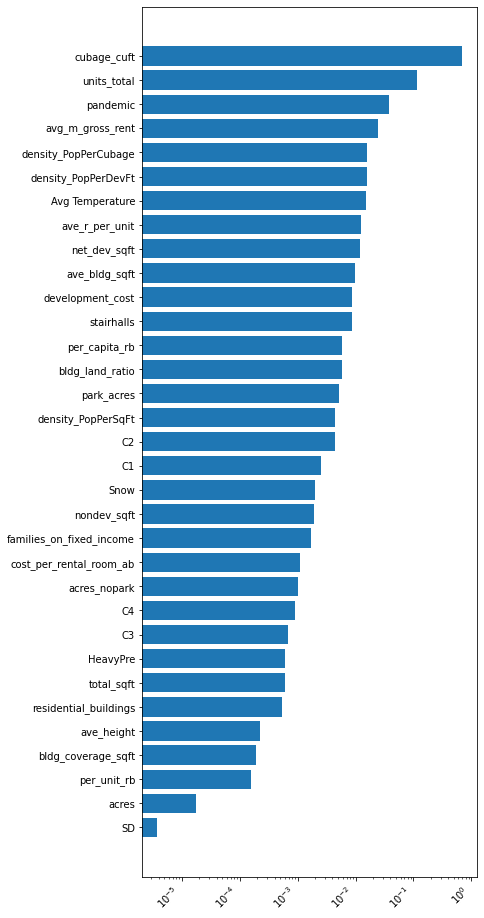

In [134]:
result = pd.DataFrame(columns = ['Predictors', 'Importance'])
result['Predictors'] = var_numeric + var_binary
result['Importance'] = clf.feature_importances_
result = result.sort_values(by = 'Importance')
#result['p_values'] = stats.coef_pval(lr_OLS, X_train, y_train)[1:]
#result['*'] = result['p_values']<0.01

fig = plt.figure(figsize = (6, 16))
plt.barh(y = result['Predictors'], width = result['Importance'], log= True)
#plt.ylim(0, 0.1)
plt.xticks(rotation=45, ha='right')
plt.show()

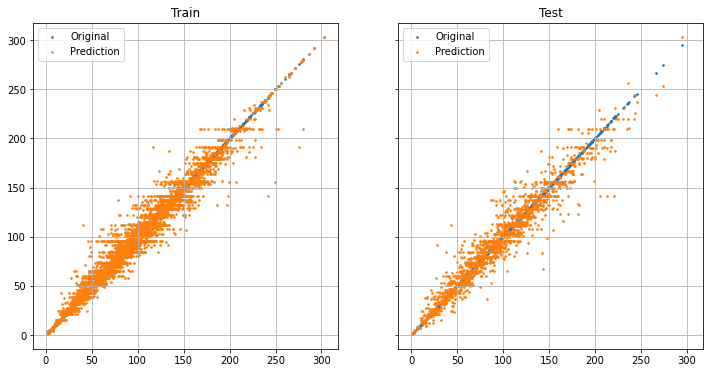

In [113]:
fig, ax = plt.subplots(figsize = (12, 6), nrows =1, ncols=2, sharex=True, sharey=True)

ax[0].scatter(x = y_train, y = y_train, s = 2.5, label = 'Original')
ax[0].scatter(x = y_train, y = y_pred_train, s = 2.5, label = 'Prediction')
#plt.ylim(0, 0.1)
#plt.xticks(rotation=45, ha='right')
ax[0].grid()
ax[0].set_title('Train')
ax[0].legend()

ax[1].scatter(x = y_test, y = y_test, s = 2.5, label = 'Original')
ax[1].scatter(x = y_test, y = y_pred_test, s = 2.5, label = 'Prediction')
ax[1].grid()
ax[1].set_title('Test')
ax[1].legend()

plt.show()

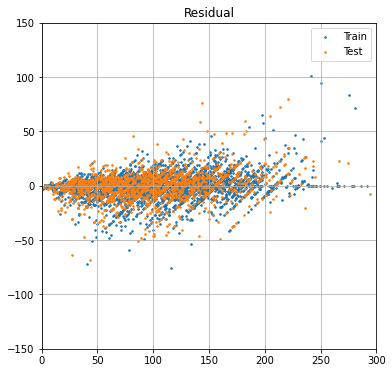

In [114]:
res_train =  y_train - y_pred_train
res_test = y_test - y_pred_test

fig, ax = plt.subplots(figsize = (6, 6), nrows =1, ncols=1, sharex=True, sharey=True)

ax.scatter(x = y_train, y= res_train, s = 2.5, label = 'Train')
ax.scatter(x = y_test, y = res_test, s = 2.5, label = 'Test')
plt.xlim(0, 300)
plt.ylim(-150, 150)
#plt.xticks(rotation=45, ha='right')
ax.grid()
ax.set_title('Residual')
ax.legend()
'''
ax[1].scatter(x = y_test, y = y_test, s = 2.5, label = 'Original')
ax[1].scatter(x = y_test, y = y_pred_test, s = 2.5, label = 'Prediction')
ax[1].grid()
ax[1].set_title('Test')
ax[1].legend()
'''
plt.show()

In [135]:
filename = '/gdrive/MyDrive/000 Spring 2022/ML/ML_FinalProject/DT.sav'
pickle.dump(clf, open(filename, 'wb'))

## Random Forest

In [115]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV

In [117]:
parameters = {'n_estimators':range(20, 50),'max_depth':range(5,15)}
rforest = RandomForestRegressor(random_state=0,criterion='squared_error')
clf = GridSearchCV(rforest, parameters, cv=5, scoring='r2')
clf.fit(X_train,y_train)
print('Best parameters:', clf.best_params_)
#print('Score from cross-validation: {:.5f}'.format(clf.best_score))

Best parameters: {'max_depth': 13, 'n_estimators': 48}


In [131]:
clf = RandomForestRegressor(max_depth =13, n_estimators =48, random_state=0, criterion='squared_error')
clf.fit(X_train,y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print("Mean Squared Error: %.3f" % mean_squared_error(y_pred_train, y_train))
print("Mean Squared Error %.3f" % mean_squared_error(y_pred_test, y_test))

Mean Squared Error: 33.046
Mean Squared Error 106.798


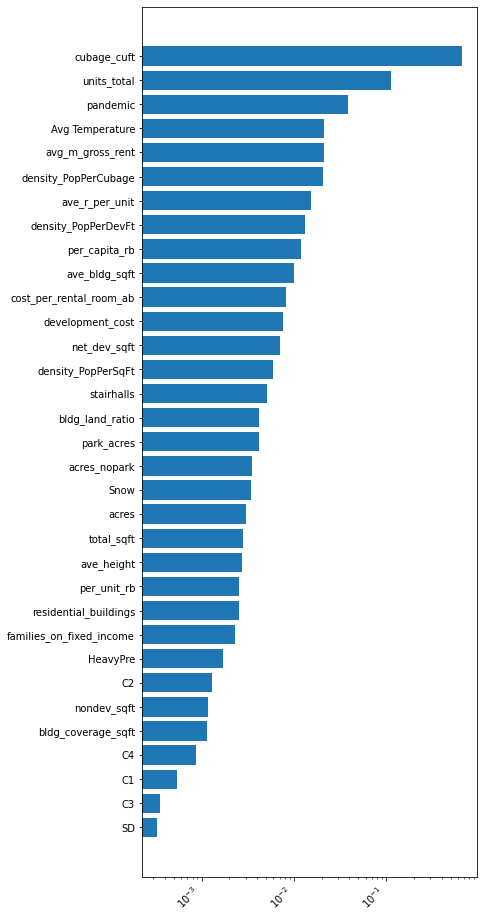

In [119]:
result = pd.DataFrame(columns = ['Predictors', 'Importance'])
result['Predictors'] = var_numeric + var_binary
result['Importance'] = clf.feature_importances_
result = result.sort_values(by='Importance')
#result['p_values'] = stats.coef_pval(lr_OLS, X_train, y_train)[1:]
#result['*'] = result['p_values']<0.01

fig = plt.figure(figsize = (6, 16))
plt.barh(y = result['Predictors'], width = result['Importance'], log= True)
#plt.ylim(0, 0.1)
plt.xticks(rotation=45, ha='right')
plt.show()

In [120]:
result.sort_values(by = 'Importance', ascending=False)

,Predictors,Importance
10,cubage_cuft,0.659963
0,units_total,0.114534
30,pandemic,0.038355
24,Avg Temperature,0.021447
15,avg_m_gross_rent,0.021139
19,density_PopPerCubage,0.020769
16,ave_r_per_unit,0.015428
18,density_PopPerDevFt,0.013385
21,per_capita_rb,0.012103
23,ave_bldg_sqft,0.010124


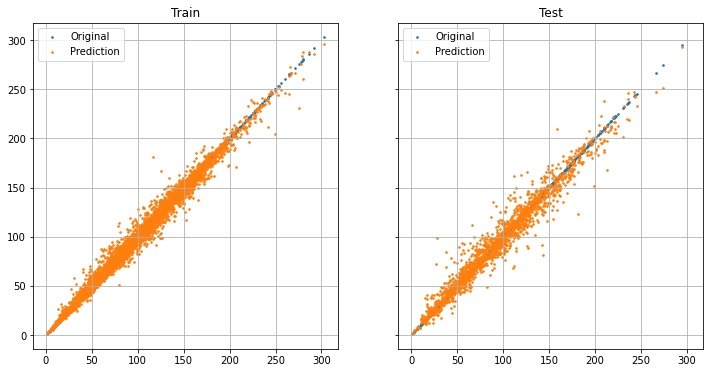

In [121]:
fig, ax = plt.subplots(figsize = (12, 6), nrows =1, ncols=2, sharex=True, sharey=True)

ax[0].scatter(x = y_train, y = y_train, s = 2.5, label = 'Original')
ax[0].scatter(x = y_train, y = y_pred_train, s = 2.5, label = 'Prediction')
#plt.ylim(0, 0.1)
#plt.xticks(rotation=45, ha='right')
ax[0].grid()
ax[0].set_title('Train')
ax[0].legend()

ax[1].scatter(x = y_test, y = y_test, s = 2.5, label = 'Original')
ax[1].scatter(x = y_test, y = y_pred_test, s = 2.5, label = 'Prediction')
ax[1].grid()
ax[1].set_title('Test')
ax[1].legend()

plt.show()

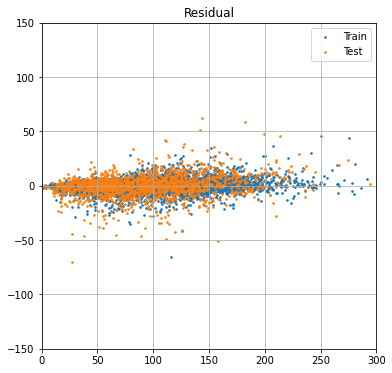

In [122]:
res_train =  y_train - y_pred_train
res_test = y_test - y_pred_test

fig, ax = plt.subplots(figsize = (6, 6), nrows =1, ncols=1, sharex=True, sharey=True)

ax.scatter(x = y_train, y= res_train, s = 2.5, label = 'Train')
ax.scatter(x = y_test, y = res_test, s = 2.5, label = 'Test')
plt.xlim(0, 300)
plt.ylim(-150, 150)
#plt.xticks(rotation=45, ha='right')
ax.grid()
ax.set_title('Residual')
ax.legend()
'''
ax[1].scatter(x = y_test, y = y_test, s = 2.5, label = 'Original')
ax[1].scatter(x = y_test, y = y_pred_test, s = 2.5, label = 'Prediction')
ax[1].grid()
ax[1].set_title('Test')
ax[1].legend()
'''
plt.show()

In [132]:
filename = '/gdrive/MyDrive/000 Spring 2022/ML/ML_FinalProject/RF.sav'
pickle.dump(clf, open(filename, 'wb'))

## Gradient Boosting

In [123]:
from sklearn.ensemble import GradientBoostingRegressor

In [124]:
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)

y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)

print("Training score: %.3f" % reg.score(X_train, y_train))
print("Testing score: %.3f" % reg.score(X_test, y_test))

print("Mean Squared Error: %.3f" % mean_squared_error(y_pred_train, y_train))
print("Mean Squared Error %.3f" % mean_squared_error(y_pred_test, y_test))

Training score: 0.930
Testing score: 0.921
Mean Squared Error: 166.089
Mean Squared Error 186.073


In [125]:
parameters = {'n_estimators':[10, 20 , 50], 
            'learning_rate': [0.1,0.05,0.02],
            'max_depth': range(5,15)} 

GBR = GradientBoostingRegressor(random_state=0,loss='squared_error')
reg = GridSearchCV(GBR, parameters, cv=5, scoring='r2')

reg.fit(X_train,y_train)
print('Best parameters:', reg.best_params_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50}


In [126]:
reg = GradientBoostingRegressor(learning_rate= 0.1, max_depth= 7, n_estimators= 50)
reg = reg.fit(X_train, y_train)

y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)

print("Training score: %.3f" % reg.score(X_train, y_train))
print("Testing score: %.3f" % reg.score(X_test, y_test))

print("Mean Squared Error: %.3f" % mean_squared_error(y_pred_train, y_train))
print("Mean Squared Error %.3f" % mean_squared_error(y_pred_test, y_test))

Training score: 0.979
Testing score: 0.955
Mean Squared Error: 50.156
Mean Squared Error 107.033


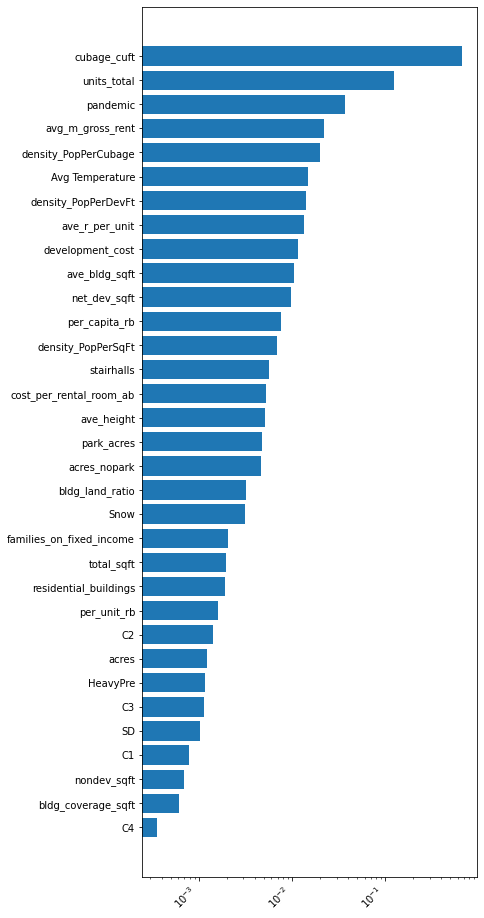

In [127]:
result = pd.DataFrame(columns = ['Predictors', 'Importance'])
result['Predictors'] = var_numeric + var_binary
result['Importance'] = reg.feature_importances_
result = result.sort_values(by='Importance')
#result['p_values'] = stats.coef_pval(lr_OLS, X_train, y_train)[1:]
#result['*'] = result['p_values']<0.01

fig = plt.figure(figsize = (6, 16))
plt.barh(y = result['Predictors'], width = result['Importance'], log= True)
#plt.ylim(0, 0.1)
plt.xticks(rotation=45, ha='right')
plt.show()

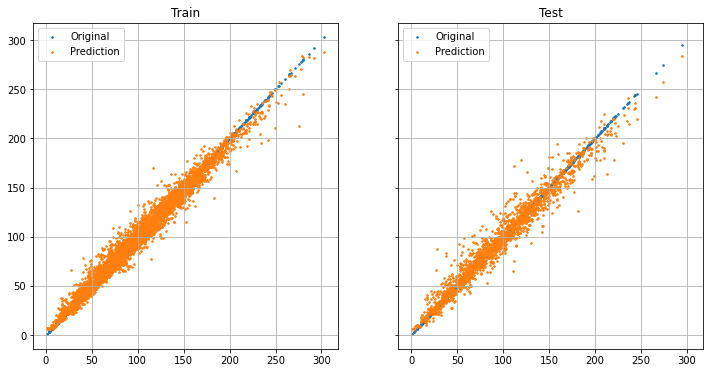

In [128]:
fig, ax = plt.subplots(figsize = (12, 6), nrows =1, ncols=2, sharex=True, sharey=True)

ax[0].scatter(x = y_train, y = y_train, s = 2.5, label = 'Original')
ax[0].scatter(x = y_train, y = y_pred_train, s = 2.5, label = 'Prediction')
#plt.ylim(0, 0.1)
#plt.xticks(rotation=45, ha='right')
ax[0].grid()
ax[0].set_title('Train')
ax[0].legend()

ax[1].scatter(x = y_test, y = y_test, s = 2.5, label = 'Original')
ax[1].scatter(x = y_test, y = y_pred_test, s = 2.5, label = 'Prediction')
ax[1].grid()
ax[1].set_title('Test')
ax[1].legend()

plt.show()

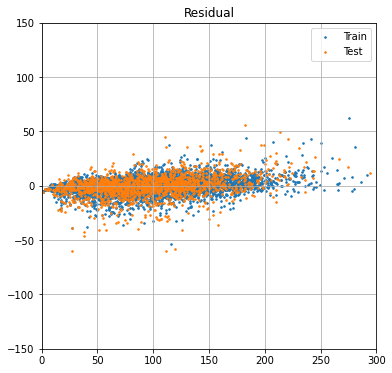

In [129]:
res_train =  y_train - y_pred_train
res_test = y_test - y_pred_test

fig, ax = plt.subplots(figsize = (6, 6), nrows =1, ncols=1, sharex=True, sharey=True)

ax.scatter(x = y_train, y= res_train, s = 2.5, label = 'Train')
ax.scatter(x = y_test, y = res_test, s = 2.5, label = 'Test')
plt.xlim(0, 300)
plt.ylim(-150, 150)
#plt.xticks(rotation=45, ha='right')
ax.grid()
ax.set_title('Residual')
ax.legend()
'''
ax[1].scatter(x = y_test, y = y_test, s = 2.5, label = 'Original')
ax[1].scatter(x = y_test, y = y_pred_test, s = 2.5, label = 'Prediction')
ax[1].grid()
ax[1].set_title('Test')
ax[1].legend()
'''
plt.show()

In [130]:
filename = '/gdrive/MyDrive/000 Spring 2022/ML/ML_FinalProject/GBRT.sav'
pickle.dump(reg, open(filename, 'wb'))